#### Audio Classification Data Preprocessing

In [280]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Flatten, Dense
from keras import Sequential
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import seaborn as sns
import IPython.display as ipd

# plotting utilities
plt.rcParams["figure.titleweight"] = 'bold'
plt.rcParams["figure.titlesize"] = 'large'
plt.rcParams['figure.dpi'] = 120
plt.style.use('fivethirtyeight')

LABEL_ENCODER = LabelEncoder()

## Sample file observation

In [151]:
audio_file_path = 'dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/3acc7440-4479-11e9-a9a5-5dbec3b8816a.wav'
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [152]:
print(librosa_audio_data)

[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.0792456e-05 7.0427333e-05
 0.0000000e+00]


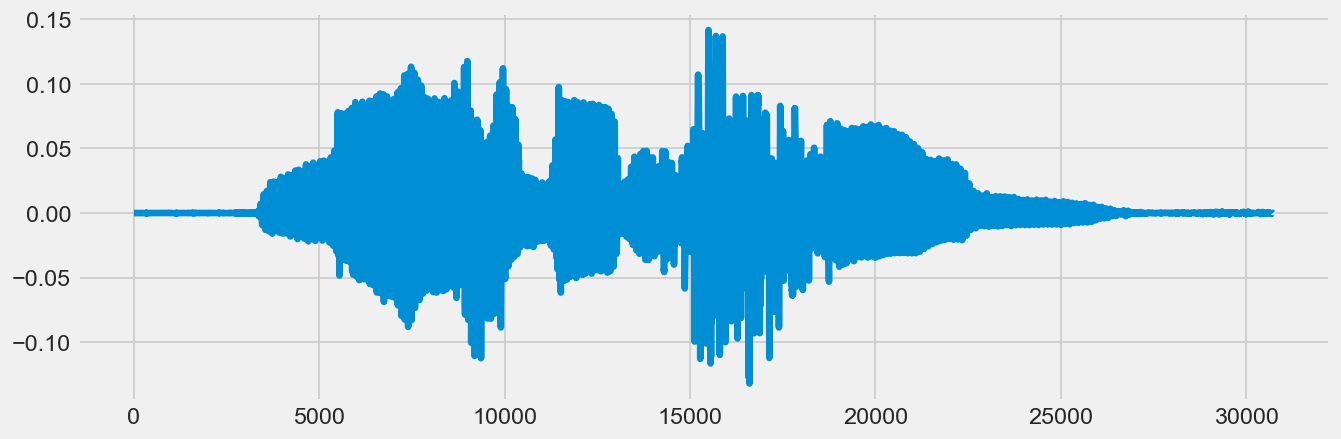

In [153]:
### Lets plot the librosa audio data
# Original audio with 1 channel
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

In [154]:
### Lets read with scipy
wave_sample_rate, wave_audio = wav.read(audio_file_path)  #%% md
#### Audio Classification Data Preprocessing

In [155]:
### Let's read a sample audio using librosa
audio_file_path = 'dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/3acc7440-4479-11e9-a9a5-5dbec3b8816a.wav'
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [156]:
print(librosa_audio_data)

[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.0792456e-05 7.0427333e-05
 0.0000000e+00]


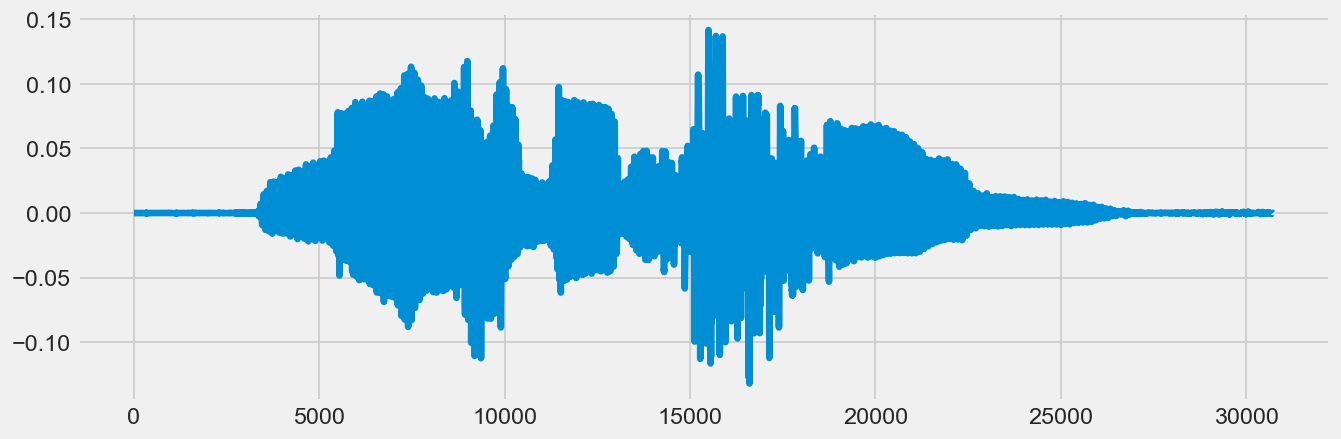

In [157]:
### Lets plot the librosa audio data
# Original audio with 1 channel
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

### Sample files observation and sample feature extraction

In [158]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 61)


In [159]:
mfccs

array([[-7.4111920e+02, -7.3793085e+02, -7.3372919e+02, ...,
        -6.9023126e+02, -6.9762494e+02, -7.0923523e+02],
       [ 2.4239032e+00,  6.8581419e+00,  1.2462606e+01, ...,
         6.7299309e+01,  5.9293739e+01,  4.5494789e+01],
       [ 2.4126921e+00,  6.6367674e+00,  1.1383302e+01, ...,
         5.1713745e+01,  4.8966675e+01,  3.9999344e+01],
       ...,
       [ 6.8582594e-05, -5.7721716e-01, -1.0462627e+00, ...,
        -9.3867071e-02,  1.1653264e+00, -9.1525936e-01],
       [-3.5943024e-02, -5.5208266e-01, -1.3430347e+00, ...,
        -3.0128503e-01,  2.2019703e+00, -3.5509074e-01],
       [-6.7360789e-02, -5.4289007e-01, -1.7864796e+00, ...,
        -6.5210921e-01,  1.7860074e+00, -3.3926344e-01]], dtype=float32)

In [160]:
melspectrogram = librosa.feature.melspectrogram(y=librosa_audio_data, sr=librosa_sample_rate, n_mels=128, fmax=8000)
print(melspectrogram.shape)

(128, 61)


In [161]:
melspectrogram

array([[1.0221391e-06, 2.5539582e-06, 3.6618874e-06, ..., 5.7139737e-06,
        9.2033797e-06, 9.3223089e-06],
       [9.8326518e-07, 4.2117449e-06, 1.3717413e-05, ..., 8.0067526e-05,
        8.4176711e-05, 2.0536820e-05],
       [8.0082214e-07, 4.1976505e-06, 2.1964148e-05, ..., 1.8297965e-04,
        1.3760786e-04, 3.0035006e-05],
       ...,
       [3.8063674e-10, 1.4444147e-09, 3.7924108e-09, ..., 6.4010410e-09,
        4.4015507e-09, 3.4318466e-09],
       [1.0439288e-11, 5.6980566e-11, 2.3711758e-10, ..., 5.1553889e-10,
        6.3354771e-10, 3.9536499e-10],
       [6.0599725e-14, 4.1958291e-13, 6.1142752e-13, ..., 2.1662633e-12,
        4.9767346e-11, 1.8454646e-10]], dtype=float32)

## Dataframe analysis
### 1) Audio files loading and cleaning

In [162]:
#### Extracting MFCC's For every audio file
audio_dataset_path = 'dsl_data/audio'
metadata = pd.read_csv('development.csv')

metadata.drop('Id', axis=1, inplace=True)
#TODO REMOVE ME
# metadata = metadata.sample(frac=0.01, random_state=42)

print(len(metadata))
metadata_to_display = metadata.copy()
metadata.head(100)

9854


,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40
1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40
2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40
3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
...,...,...,...,...,...,...,...,...,...
95,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/c4808...,2BqVo8kVB2Skwgyb,increase,heat,advanced,English (United States),English (United States),female,22-40
96,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/2d859...,2BqVo8kVB2Skwgyb,decrease,heat,advanced,English (United States),English (United States),female,22-40
97,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/32ff8...,2BqVo8kVB2Skwgyb,decrease,heat,advanced,English (United States),English (United States),female,22-40
98,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/34e73...,2BqVo8kVB2Skwgyb,decrease,heat,advanced,English (United States),English (United States),female,22-40


In [163]:
from scipy.io import wavfile

file_audio_data = []
ds_files = metadata_to_display['path'].tolist()
for file in ds_files:
    label = (file.split("_"))[1][0]
    rate, data = wavfile.read(file)
    file_audio_data.append(data.astype(np.float16))
print(len(file_audio_data))

9854


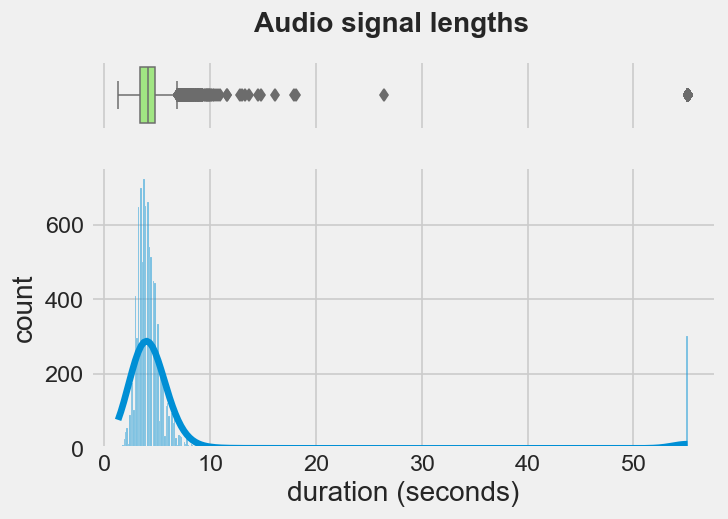

In [164]:
def show_length_distribution(signals, rate=8000):
    sampel_times = [len(x) / rate for x in signals]

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})

    # Add a graph in each part
    sns.boxplot(x=sampel_times, ax=ax_box, linewidth=0.9, color='#9af772')
    sns.histplot(x=sampel_times, ax=ax_hist, bins='fd', kde=True)

    # Remove x-axis name for the boxplot
    ax_box.set(xlabel='')

    title = 'Audio signal lengths'
    x_label = 'duration (seconds)'
    y_label = 'count'

    plt.suptitle(title)
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel(y_label)
    plt.show()
    return sampel_times


lengths = show_length_distribution(file_audio_data)

In [165]:
q = 90
np.percentile(lengths, q)

5.973375

In [166]:
tot_outliers = sum(map(lambda x: x > np.percentile(lengths, q), lengths))
print(f'Values outside {q} percentile: {tot_outliers}')

Values outside 90 percentile: 925


20.0


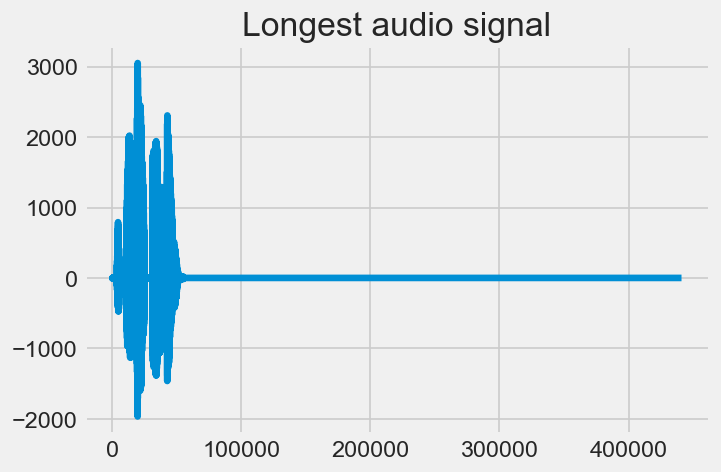

In [167]:
Longest_audio = np.argmax([len(x) for x in file_audio_data])
plt.plot(file_audio_data[Longest_audio])
plt.title("Longest audio signal")

ipd.Audio(file_audio_data[Longest_audio], rate=rate)
print(librosa.get_duration(file_audio_data[Longest_audio]))

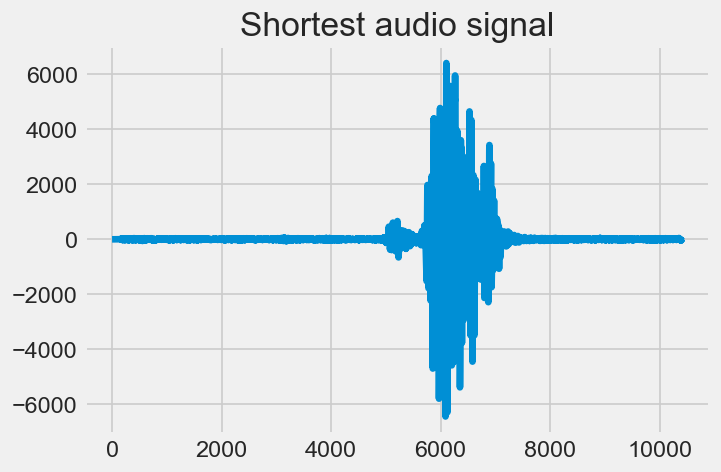

In [168]:
Shortest_audio = np.argmin([len(x) for x in file_audio_data])
plt.plot(file_audio_data[Shortest_audio])
plt.title("Shortest audio signal")

ipd.Audio(file_audio_data[Shortest_audio], rate=rate)

In [169]:
from librosa.effects import trim


# by default anything below 10 db is considered as silence
def remove_silence(sample, sr=8000, top_db=10):
    """This function removes trailing and leading silence periods of audio signals.
    """
    y = np.array(sample, dtype=np.float64)
    # Trim the beginning and ending silence
    yt, _ = trim(y, top_db=top_db)
    return yt

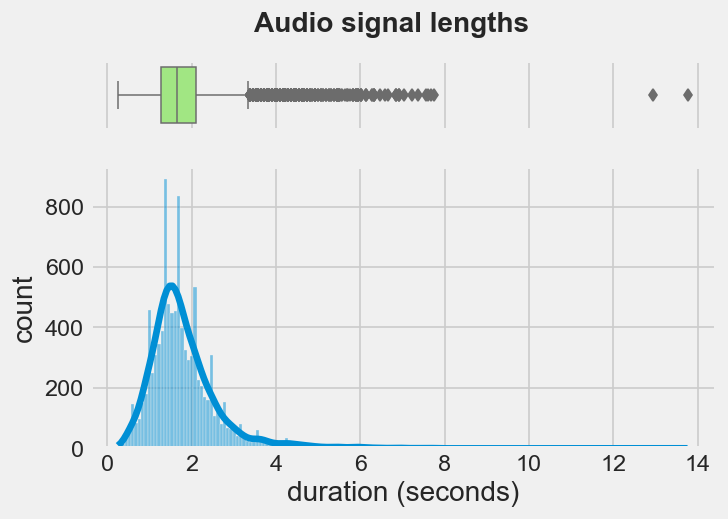

In [170]:
file_audio_data_trimmed = [remove_silence(x) for x in file_audio_data]

show_length_distribution(file_audio_data_trimmed);

In [171]:
metadata_to_display["audio"] = file_audio_data_trimmed
print(len(metadata_to_display))

9854


In [172]:
metadata_to_display.insert(loc=0, column="duration", value=None)
metadata_to_display['duration'] = metadata_to_display['audio'].apply(lambda x: librosa.get_duration(x))
metadata_to_display

,duration,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,audio
0,0.72,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40,"[-8.0, -159.0, 294.0, -355.0, -256.0, 714.0, -..."
1,0.42,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40,"[0.0, -3.0, -6.0, -6.0, -11.0, -16.0, -16.0, -..."
2,0.81,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40,"[12.0, 10.0, 10.0, 10.0, 9.0, 11.0, 14.0, 14.0..."
3,0.60,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,"[821.0, 809.0, 658.0, 301.0, -159.0, -536.0, -..."
4,1.02,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
9849,0.63,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,English (United States),English (United States),male,22-40,"[342.0, 207.0, 125.0, 190.0, 295.0, 331.0, 236..."
9850,0.60,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,"[226.0, 181.0, 167.0, 159.0, 153.0, 134.0, 10...."
9851,0.77,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,"[-87.0, -13.0, 156.0, 467.0, 653.0, 530.0, 379..."
9852,0.42,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,"[226.0, 243.0, 250.0, 248.0, 266.0, 281.0, 293..."


In [173]:
metadata_to_display

,duration,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,audio
0,0.72,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40,"[-8.0, -159.0, 294.0, -355.0, -256.0, 714.0, -..."
1,0.42,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40,"[0.0, -3.0, -6.0, -6.0, -11.0, -16.0, -16.0, -..."
2,0.81,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40,"[12.0, 10.0, 10.0, 10.0, 9.0, 11.0, 14.0, 14.0..."
3,0.60,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,"[821.0, 809.0, 658.0, 301.0, -159.0, -536.0, -..."
4,1.02,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
9849,0.63,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,English (United States),English (United States),male,22-40,"[342.0, 207.0, 125.0, 190.0, 295.0, 331.0, 236..."
9850,0.60,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,"[226.0, 181.0, 167.0, 159.0, 153.0, 134.0, 10...."
9851,0.77,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,"[-87.0, -13.0, 156.0, 467.0, 653.0, 530.0, 379..."
9852,0.42,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,"[226.0, 243.0, 250.0, 248.0, 266.0, 281.0, 293..."


In [174]:
metadata_to_display.drop('duration', axis=1, inplace=True)

In [175]:
print(len(metadata_to_display))

9854


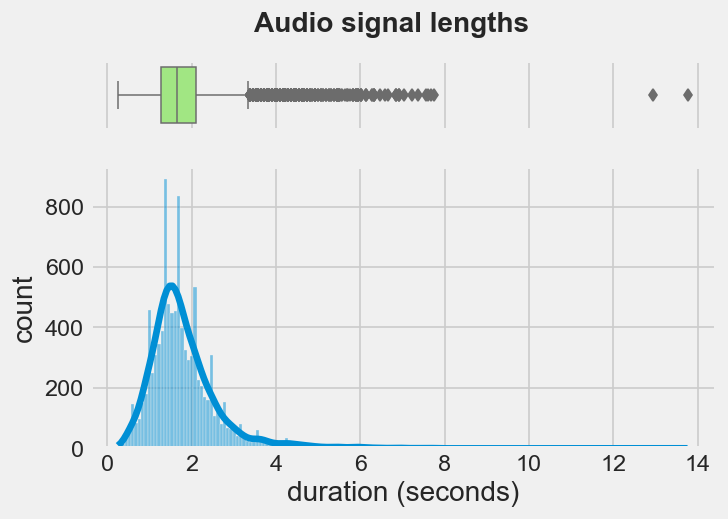

[1.984,
 1.152,
 2.24,
 1.664,
 2.816,
 3.328,
 3.392,
 2.432,
 2.56,
 3.072,
 1.984,
 3.072,
 1.792,
 1.664,
 1.408,
 3.2,
 1.536,
 1.344,
 1.664,
 2.56,
 3.52,
 2.496,
 1.664,
 6.336,
 6.592,
 7.744,
 2.688,
 3.136,
 2.368,
 1.28,
 1.792,
 2.432,
 2.944,
 1.28,
 1.984,
 2.368,
 4.48,
 4.288,
 3.264,
 3.2,
 4.288,
 2.56,
 1.152,
 0.384,
 1.408,
 1.088,
 3.328,
 1.856,
 2.688,
 2.048,
 1.984,
 2.432,
 1.984,
 1.984,
 1.92,
 2.816,
 2.752,
 1.6,
 2.88,
 3.776,
 2.368,
 3.52,
 2.56,
 0.32,
 1.28,
 2.88,
 1.984,
 1.536,
 1.984,
 1.024,
 1.536,
 2.88,
 1.792,
 1.216,
 6.336,
 7.552,
 2.432,
 3.456,
 3.008,
 1.984,
 1.28,
 1.728,
 2.432,
 2.112,
 3.008,
 1.472,
 2.368,
 2.816,
 4.416,
 6.912,
 3.52,
 3.136,
 3.712,
 4.544,
 2.56,
 1.088,
 2.176,
 1.344,
 0.832,
 3.264,
 2.688,
 3.776,
 1.408,
 2.688,
 2.496,
 1.856,
 0.576,
 1.024,
 1.664,
 1.536,
 1.664,
 0.96,
 1.152,
 1.664,
 1.6,
 1.28,
 1.28,
 1.088,
 1.216,
 1.344,
 1.216,
 1.344,
 1.344,
 1.088,
 1.024,
 2.048,
 1.344,
 0.64,
 0.576,

In [176]:
show_length_distribution(metadata_to_display['audio'].tolist())

In [177]:
# metadata.drop('duration', axis=1, inplace=True)

### 3) Non-audio feature analysis


In [178]:
def get_unique_data(target_dataframe, end_target_columns):
    df_last_7_columns = target_dataframe.iloc[:, -end_target_columns:]
    unique_values = {col: df_last_7_columns[col].unique() for col in df_last_7_columns.columns}
    unique_series = pd.Series(unique_values)
    return unique_series


In [179]:
df_unique_data = get_unique_data(metadata, 5)
df_unique_data

Self-reported fluency level                        [advanced, native, basic, intermediate]
First Language spoken                    [English (United States), French (Canada), Eng...
Current language used for work/school    [English (United States), English (Canada), En...
gender                                                                      [female, male]
ageRange                                                               [22-40, 41-65, 65+]
dtype: object

In [180]:
eval_df = pd.read_csv('evaluation.csv')

df_unique_data = get_unique_data(eval_df, 5)
df_unique_data

Self-reported fluency level                               [native]
First Language spoken                    [English (United States)]
Current language used for work/school    [English (United States)]
gender                                              [male, female]
ageRange                                            [22-40, 41-65]
dtype: object

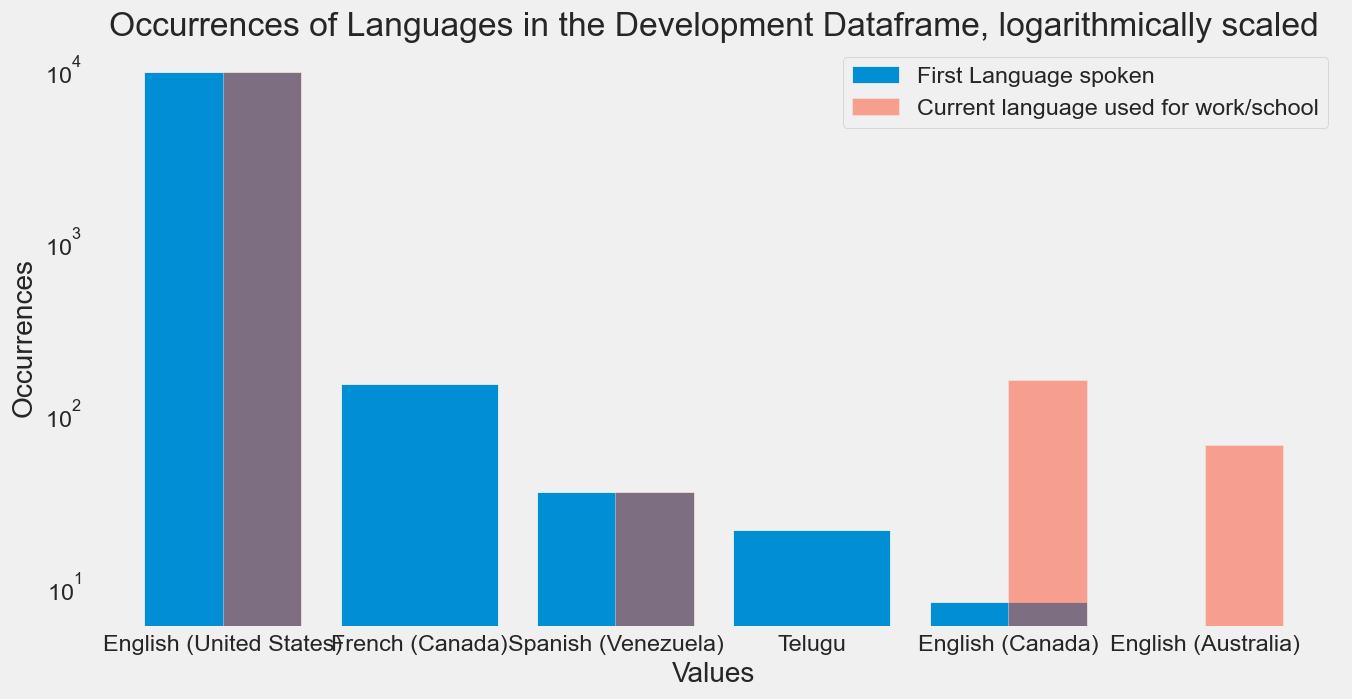

In [181]:
dev_df = metadata.copy()
col1_counts = dev_df['First Language spoken'].value_counts()

# Count the occurrences of each value in the second column
col2_counts = dev_df['Current language used for work/school'].value_counts()

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(col1_counts.index, col1_counts.values, label='First Language spoken')
ax.bar(col2_counts.index, col2_counts.values, label='Current language used for work/school', width=0.4, align='edge',
       alpha=0.5)

# Add a legend and display the chart
ax.legend()
ax.set_yscale('log')  # this line add the y-axis scaling to logarithmic
plt.xlabel("Values")
plt.grid()
plt.ylabel("Occurrences")
plt.title("Occurrences of Languages in the Development Dataframe, logarithmically scaled")
plt.show()

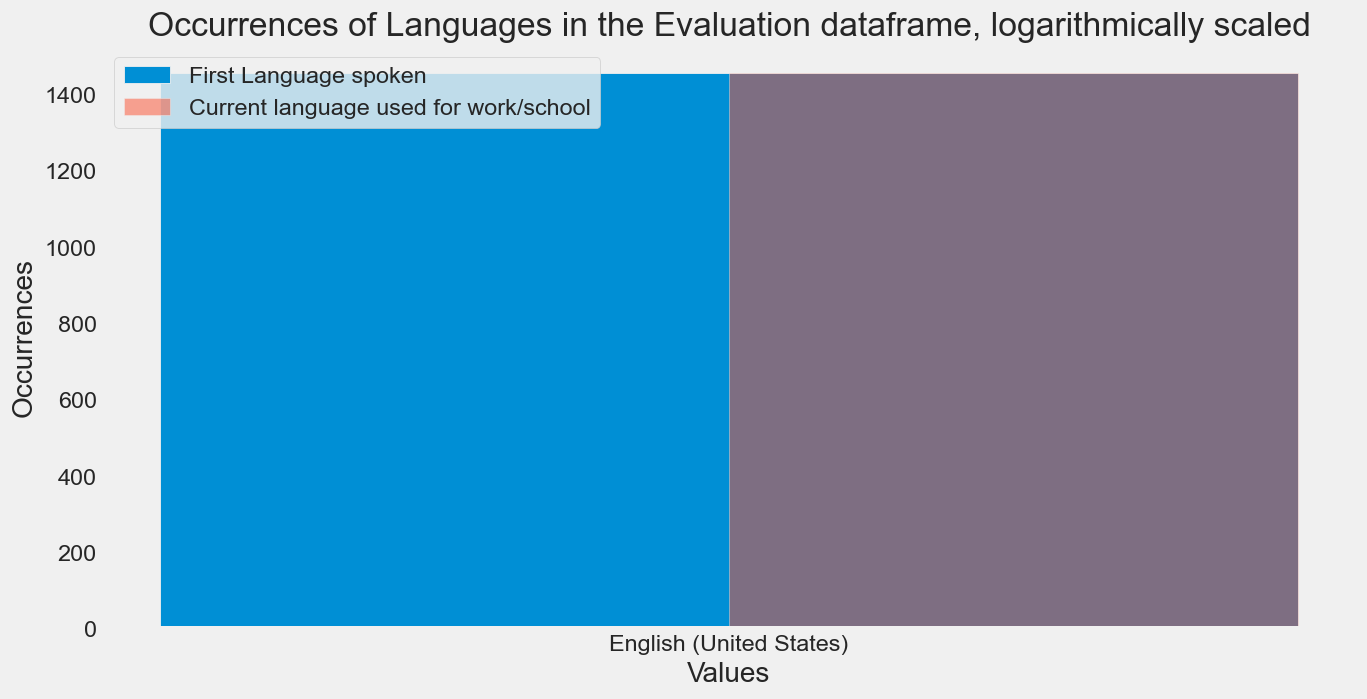

In [182]:
col1_counts = eval_df['First Language spoken'].value_counts()

# Count the occurrences of each value in the second column
col2_counts = eval_df['Current language used for work/school'].value_counts()

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(col1_counts.index, col1_counts.values, label='First Language spoken')
ax.bar(col2_counts.index, col2_counts.values, label='Current language used for work/school', width=0.4, align='edge',
       alpha=0.5)

# Add a legend and display the chart
ax.legend()
plt.xlabel("Values")
plt.grid()
plt.ylabel("Occurrences")
plt.title("Occurrences of Languages in the Evaluation dataframe, logarithmically scaled")
plt.show()

In [183]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9854 entries, 0 to 9853
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   path                                   9854 non-null   object
 1   speakerId                              9854 non-null   object
 2   action                                 9854 non-null   object
 3   object                                 9854 non-null   object
 4   Self-reported fluency level            9854 non-null   object
 5   First Language spoken                  9854 non-null   object
 6   Current language used for work/school  9854 non-null   object
 7   gender                                 9854 non-null   object
 8   ageRange                               9854 non-null   object
dtypes: object(9)
memory usage: 693.0+ KB


# Dataframe cleaning after analisys

In [184]:
before = len(metadata)
print()
metadata.drop(metadata[metadata['First Language spoken'] != 'English (United States)'].index, inplace=True)
metadata.drop(metadata[metadata['Current language used for work/school'] != 'English (United States)'].index,
              inplace=True)
after = len(metadata)
print(before)
print(after)
difference = before - after
print(str(difference))
print(str(((difference / before) * 100)) + "%")



9854
9577
277
2.811041201542521%


In [185]:
metadata.drop('First Language spoken', axis=1, inplace=True)
metadata.drop('Current language used for work/school', axis=1, inplace=True)
metadata

,path,speakerId,action,object,Self-reported fluency level,gender,ageRange
0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,female,22-40
1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,female,22-40
2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,female,22-40
3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,female,22-40
4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,female,22-40
...,...,...,...,...,...,...,...
9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,male,22-40
9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,male,22-40
9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,male,22-40
9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,male,22-40


In [186]:
mapping = {metadata.columns[4]: 'Fluency', }
metadata = metadata.rename(columns=mapping)
metadata

,path,speakerId,action,object,Fluency,gender,ageRange
0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,female,22-40
1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,female,22-40
2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,female,22-40
3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,female,22-40
4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,female,22-40
...,...,...,...,...,...,...,...
9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,male,22-40
9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,male,22-40
9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,male,22-40
9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,male,22-40


### Utility functions

In [187]:
def mfccs_extractor(file):
    # audio, sr = load_and_clean_audio(file)
    audio, sr = librosa.load(file)
    audio, _ = librosa.effects.trim(audio)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=librosa_sample_rate, n_mfcc=140)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [188]:
def spectogram_extractor(file):
    # audio, sr = load_and_clean_audio(file)
    audio, sr = librosa.load(file)
    audio, _ = librosa.effects.trim(audio)
    melspectrogram = librosa.feature.melspectrogram(y=audio, sr=librosa_sample_rate, n_mels=128, fmax=8000)
    melspectrogram_scaled_features = np.mean(melspectrogram.T, axis=0)
    return melspectrogram_scaled_features

In [189]:
def create_sentence(row):
    return row["action"] + row["object"]

### Rearranging the dataframe

In [190]:
from sklearn.preprocessing import OneHotEncoder

fluency_encoder = OneHotEncoder()


def rearrange_dataframe(reg_df, evaluation=False):
    tqdm.pandas(ncols=50)

    reg_df["mfccs_scaled_features"] = reg_df['path'].progress_apply(lambda path: mfccs_extractor(path))
    reg_df["spectogram_features"] = reg_df['path'].progress_apply(lambda path: spectogram_extractor(path))
    reg_df.drop('path', axis=1, inplace=True)

    one_hot = pd.get_dummies(reg_df['gender'])
    reg_df = reg_df.join(one_hot)
    reg_df.drop('gender', axis=1, inplace=True)

    # one_hot = pd.get_dummies(reg_df['speakerId'])
    # reg_df = reg_df.join(one_hot)
    reg_df.drop('speakerId', axis=1, inplace=True)

    # encoded_column = fluency_encoder.fit_transform(reg_df[['Fluency']])
    # encoded_column_names = fluency_encoder.get_feature_names_out(['Fluency'])
    # reg_df = pd.concat([reg_df, pd.DataFrame(encoded_column.toarray(), columns=encoded_column_names)], axis=1)
    reg_df.drop('Fluency', axis=1, inplace=True)

    another_encoder = LabelEncoder()
    reg_df['ageRange'] = another_encoder.fit_transform(reg_df['ageRange'])
    reg_df = reg_df.reindex(sorted(reg_df.columns), axis=1)

    if not evaluation:
        reg_df["sentence"] = reg_df.progress_apply(create_sentence, axis=1)
        reg_df.drop('action', axis=1, inplace=True)
        reg_df.drop('object', axis=1, inplace=True)

    return reg_df.copy()

In [191]:
w_metadata = metadata.copy()
w_metadata

,path,speakerId,action,object,Fluency,gender,ageRange
0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,female,22-40
1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,female,22-40
2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,female,22-40
3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,female,22-40
4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,female,22-40
...,...,...,...,...,...,...,...
9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,male,22-40
9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,male,22-40
9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,male,22-40
9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,male,22-40


In [192]:
w_metadata = rearrange_dataframe(w_metadata, evaluation=False)
w_metadata

100%|█████| 9577/9577 [00:00<00:00, 106986.55it/s]


,ageRange,female,male,mfccs_scaled_features,spectogram_features,sentence
0,0,1,0,"[-508.36096, 55.001785, -28.398558, 58.82987, ...","[7.0757036e-05, 0.00016309676, 0.00065370527, ...",change languagenone
1,0,1,0,"[-589.7854, 83.17272, 6.3914456, 35.428726, -7...","[6.827641e-05, 9.0469526e-05, 0.000111092624, ...",activatemusic
2,0,1,0,"[-632.3232, 117.935394, -6.7135935, 11.537451,...","[3.745495e-05, 0.0001055681, 0.00042638168, 0....",deactivatelights
3,0,1,0,"[-451.68845, 127.21898, -31.959885, 20.865711,...","[0.01077371, 0.10135703, 0.39884716, 1.1283432...",increasevolume
4,0,1,0,"[-667.8234, 114.18368, 10.975331, -2.496258, 1...","[0.002472366, 0.032411344, 0.098514386, 0.1049...",increasevolume
...,...,...,...,...,...,...
9849,0,0,1,"[-463.23517, 86.606964, -7.1176476, 26.333221,...","[0.17780903, 0.010965303, 0.016069291, 0.12706...",decreasevolume
9850,0,0,1,"[-467.0342, 65.14016, -14.032764, 31.461567, -...","[0.17176418, 0.005633395, 0.008156301, 0.11034...",deactivatelights
9851,0,0,1,"[-434.6966, 82.03012, -20.899393, 25.840462, -...","[0.18851712, 0.009013464, 0.016889825, 0.03234...",deactivatelights
9852,0,0,1,"[-490.15518, 63.094467, -9.64386, 27.813547, -...","[0.188645, 0.0058759963, 0.0064189406, 0.01714...",deactivatelights


In [193]:
w_metadata

,ageRange,female,male,mfccs_scaled_features,spectogram_features,sentence
0,0,1,0,"[-508.36096, 55.001785, -28.398558, 58.82987, ...","[7.0757036e-05, 0.00016309676, 0.00065370527, ...",change languagenone
1,0,1,0,"[-589.7854, 83.17272, 6.3914456, 35.428726, -7...","[6.827641e-05, 9.0469526e-05, 0.000111092624, ...",activatemusic
2,0,1,0,"[-632.3232, 117.935394, -6.7135935, 11.537451,...","[3.745495e-05, 0.0001055681, 0.00042638168, 0....",deactivatelights
3,0,1,0,"[-451.68845, 127.21898, -31.959885, 20.865711,...","[0.01077371, 0.10135703, 0.39884716, 1.1283432...",increasevolume
4,0,1,0,"[-667.8234, 114.18368, 10.975331, -2.496258, 1...","[0.002472366, 0.032411344, 0.098514386, 0.1049...",increasevolume
...,...,...,...,...,...,...
9849,0,0,1,"[-463.23517, 86.606964, -7.1176476, 26.333221,...","[0.17780903, 0.010965303, 0.016069291, 0.12706...",decreasevolume
9850,0,0,1,"[-467.0342, 65.14016, -14.032764, 31.461567, -...","[0.17176418, 0.005633395, 0.008156301, 0.11034...",deactivatelights
9851,0,0,1,"[-434.6966, 82.03012, -20.899393, 25.840462, -...","[0.18851712, 0.009013464, 0.016889825, 0.03234...",deactivatelights
9852,0,0,1,"[-490.15518, 63.094467, -9.64386, 27.813547, -...","[0.188645, 0.0058759963, 0.0064189406, 0.01714...",deactivatelights


In [194]:
w_metadata_columns = w_metadata.columns.tolist()
print(len(w_metadata_columns))

6


In [195]:
w_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9577 entries, 0 to 9853
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ageRange               9577 non-null   int32 
 1   female                 9577 non-null   uint8 
 2   male                   9577 non-null   uint8 
 3   mfccs_scaled_features  9577 non-null   object
 4   spectogram_features    9577 non-null   object
 5   sentence               9577 non-null   object
dtypes: int32(1), object(3), uint8(2)
memory usage: 613.4+ KB


In [196]:
train_np = np.array(w_metadata['mfccs_scaled_features'].tolist())
print(train_np.shape)
w_metadata.drop('mfccs_scaled_features', axis=1, inplace=True)

spect_np = np.array(w_metadata['spectogram_features'].tolist())
print(spect_np.shape)
w_metadata.drop('spectogram_features', axis=1, inplace=True)
train_np = np.append(train_np, spect_np, axis=1)

sentence_df = w_metadata['sentence']
sentences_list = np.array(w_metadata['sentence'].tolist())
w_metadata.drop('sentence', axis=1, inplace=True)

training_df_converted = w_metadata.to_numpy()
print(training_df_converted.shape)
w_metadata.head()

(9577, 128)
(9577, 128)
(9577, 3)


,ageRange,female,male
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [197]:
train_np = np.append(train_np, training_df_converted, axis=1)
train_np.shape

(9577, 259)

In [198]:
from sklearn.preprocessing import LabelEncoder

SENTENCE_ENCODER_1_DIM = LabelEncoder()
y_1_dim = SENTENCE_ENCODER_1_DIM.fit_transform(sentences_list)
y_1_dim

array([1, 0, 2, ..., 2, 2, 6], dtype=int64)

In [199]:
sentence_np = pd.get_dummies(sentence_df).to_numpy()
sentence_np

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

### Preparing the evaluation dataframe

In [200]:
evaluation_df = pd.read_csv('evaluation.csv')
evaluation_df.drop('Id', axis=1, inplace=True)

#TODO REMOVE ME
# evaluation_df = evaluation_df.sample(frac=0.1, random_state=42)

mapping = {evaluation_df.columns[2]: 'Fluency', }
evaluation_df = evaluation_df.rename(columns=mapping)

evaluation_df.head()

,path,speakerId,Fluency,First Language spoken,Current language used for work/school,gender,ageRange
0,dsl_data/audio/speakers/NgQEvO2x7Vh3xy2xz/f53c...,NgQEvO2x7Vh3xy2xz,native,English (United States),English (United States),male,22-40
1,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/1d5f8...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40
2,dsl_data/audio/speakers/7B4XmNppyrCK977p/1c0d5...,7B4XmNppyrCK977p,native,English (United States),English (United States),male,41-65
3,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/275c3...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40
4,dsl_data/audio/speakers/V4ZbwLm9G5irobWn/b7c7a...,V4ZbwLm9G5irobWn,native,English (United States),English (United States),female,41-65


In [201]:
evaluation_df.drop('First Language spoken', axis=1, inplace=True)
evaluation_df.drop('Current language used for work/school', axis=1, inplace=True)

In [202]:
eval_rearranged = rearrange_dataframe(evaluation_df, evaluation=True)

100%|█████████| 1455/1455 [01:17<00:00, 18.73it/s]


In [203]:
eval_np = np.array(eval_rearranged['mfccs_scaled_features'].tolist())
eval_rearranged.drop('mfccs_scaled_features', axis=1, inplace=True)
print(eval_np.shape)

spect_np = np.array(eval_rearranged['spectogram_features'].tolist())
eval_rearranged.drop('spectogram_features', axis=1, inplace=True)
eval_np = np.append(eval_np, spect_np, axis=1)
print(spect_np.shape)

evaluation_df_converted = eval_rearranged.to_numpy()
print(evaluation_df_converted.shape)

(1455, 128)
(1455, 128)
(1455, 3)


In [204]:
eval_rearranged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455 entries, 0 to 1454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ageRange  1455 non-null   int32
 1   female    1455 non-null   uint8
 2   male      1455 non-null   uint8
dtypes: int32(1), uint8(2)
memory usage: 8.7 KB


In [205]:
w_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9577 entries, 0 to 9853
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ageRange  9577 non-null   int32
 1   female    9577 non-null   uint8
 2   male      9577 non-null   uint8
dtypes: int32(1), uint8(2)
memory usage: 389.0 KB


In [206]:
evaluation_df_columns = eval_rearranged.columns.tolist()
print(w_metadata_columns == evaluation_df_columns)
print(str(len(w_metadata_columns)) + " " + str(len(eval_rearranged)))

False
6 1455


In [207]:
eval_np = np.append(eval_np, evaluation_df_converted, axis=1)
eval_np.shape

(1455, 259)

In [208]:
eval_np.shape

(1455, 259)

## Training and testing a model

In [209]:
X_train, X_test, y_train, y_test = train_test_split(train_np, y_1_dim, test_size=0.2, random_state=42)

In [210]:
X_train.shape

(7661, 259)

In [211]:
X_test.shape

(1916, 259)

In [212]:
y_train.shape

(7661,)

In [213]:
y_test.shape

(1916,)

In [214]:
y_train

array([4, 4, 4, ..., 6, 5, 5], dtype=int64)

In [215]:
X_train

array([[-336.72262573,  160.84408569,  -51.38344955, ...,    0.        ,
           0.        ,    1.        ],
       [-420.7371521 ,   73.82574463,    0.95157313, ...,    1.        ,
           1.        ,    0.        ],
       [-378.24890137,  111.46609497,  -12.13446999, ...,    1.        ,
           0.        ,    1.        ],
       ...,
       [-341.24630737,  198.83370972,  -25.4385891 , ...,    0.        ,
           0.        ,    1.        ],
       [-339.8208313 ,   95.41716003,    3.84083033, ...,    1.        ,
           0.        ,    1.        ],
       [-399.30706787,   95.00905609,  -36.5290184 , ...,    1.        ,
           1.        ,    0.        ]])

## Testing the collected data with LazyClassifier

In [283]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=None)
models, lazyc_predictions = clf.fit(X_train, X_test, y_train, y_test)
models

## Chose a ML algorithm from LazyClassifier

In [284]:
from xgboost import XGBClassifier  #Accuracy: 0.495
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score = accuracy_score(y_test, y_pred)
print('Accuracy: %.3f' % accuracy_score)

Accuracy: 0.506


In [285]:
from sklearn.model_selection import GridSearchCV

param_grid = {'learning_rate': [0.5, 0.1, 0.01, 0.001],
              'n_estimators': [100, 200, 300, 400],
              'num_leaves': [20,31, 50, 100]}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print('Best parameters: ', grid_search.best_params_)
print('Best accuracy: %.3f' % grid_search.best_score_)

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'n_estimators': [100, 200, 300, 400, 500],
              'max_depth': [3, 5, 7, 8, 9]}

random_search = RandomizedSearchCV(model, param_grid, cv=5, n_iter=10, scoring='accuracy')
random_search.fit(X_train, y_train)

print('Best parameters: ', random_search.best_params_)
print('Best accuracy: %.3f' % random_search.best_score_)

In [ ]:
predictions = []
if grid_search.best_score_ > accuracy_score:
    predictions = grid_search.predict(eval_np)
elif random_search.best_score_ > accuracy_score:
    predictions = grid_search.predict(eval_np)
else:
    predictions = model.predict(eval_np)
print(predictions.shape)
array = SENTENCE_ENCODER_1_DIM.inverse_transform(predictions)
print(array)

In [ ]:
import matplotlib

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cm = cm / cm.sum(axis=1)[:, np.newaxis] * 100
# Plot the confusion matrix
plt.imshow(cm, cmap='Blues', interpolation='nearest')

# Remove the grid
plt.grid(False)

class_names = SENTENCE_ENCODER_1_DIM.inverse_transform([0, 1, 2, 3, 4, 5, 6])
plt.xticks([0, 1, 2, 3, 4, 5, 6], class_names)
plt.yticks([0, 1, 2, 3, 4, 5, 6], class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]:.1f}%",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > 50 else "black")
plt.xticks(rotation=45, ha='right')
plt.figure(figsize=(0.5, 1))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 32}

matplotlib.rc('font', **font)

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y_test, accuracy_score, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [ ]:
df = pd.DataFrame(array)
df.to_csv('evaluation2.csv', sep='\t')